## Load Libraries

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from IPython.display import clear_output
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
from bettermdptools.utils.test_env import TestEnv
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from bettermdptools.algorithms.rl import RL

## Value Iteration

In [2]:
np.random.seed(2)
grid_size = generate_random_map(size=20, p=0.9)
black_color_code = '\033[30m'  # Black color for 'S'
blue_color_code = '\033[34m'   # Blue color for 'F'
red_color_code = '\033[91m'    # Red color for 'H'
green_color_code = '\033[92m'  # Green color for 'G'
reset_color_code = '\033[0m'   # Reset color to default
for row in grid_size:
    colored_row = ''  # Initialize an empty string to store the colored row
    # Iterate through each character in the row
    for char in row:
        # Check the character and add the corresponding color code
        if char == 'S':
            colored_row += black_color_code + char + reset_color_code + ' '  # Add 'S' in black color
        elif char == 'F':
            colored_row += blue_color_code + char + reset_color_code + ' '   # Add 'F' in blue color
        elif char == 'H':
            colored_row += red_color_code + char + reset_color_code + ' '    # Add 'H' in red color
        elif char == 'G':
            colored_row += green_color_code + char + reset_color_code + ' '  # Add 'G' in green color
        else:
            colored_row += char + ' '  # Add other characters with default color
    # Print the colored row
    print(colored_row)

S F F F F F F F F F F F F F F F F F F F 
F F F F F F F F F F F F F F F F F F F F 
H F F F F F F F F H F F F F F F F F H H 
F F F F F F F F H F F F F F F F F F F F 
F F F F F F F F H F F F F F F F F F F F 
F F F F F F F H F F F H F F F F F F F F 
F F F F F F F F F F F F F F F F F H F F 
F F F F F F F F F F F F F F F F F F F F 
F F F F F H F F F F F F F F F F F F F H 
F F F F F F F F F F H F F F F F H F H F 
F F F F F F F F F H H F F F F F F F F F 
F F F F F F F F F F F F F F F F H F F F 
F F F F F F H F F F F F F F F F F F F F 
F F F F F F F H F F F F F F F F F H H F 
F F F H F F F F F F F F F F F F F F F F 
F F F F H F F F F F H F H F F F F H F F 
F F H F F F F F F F F F F F F H F F F F 
F F F F F F F F F F F F H F F H F F H F 
F F F F F F F F F F F F H F F F F F F F 
F F F H F F F F F F F F F F F F F F F G 


runtime = 0.19 seconds
runtime = 0.35 seconds
runtime = 0.52 seconds
runtime = 0.92 seconds
runtime = 1.39 seconds


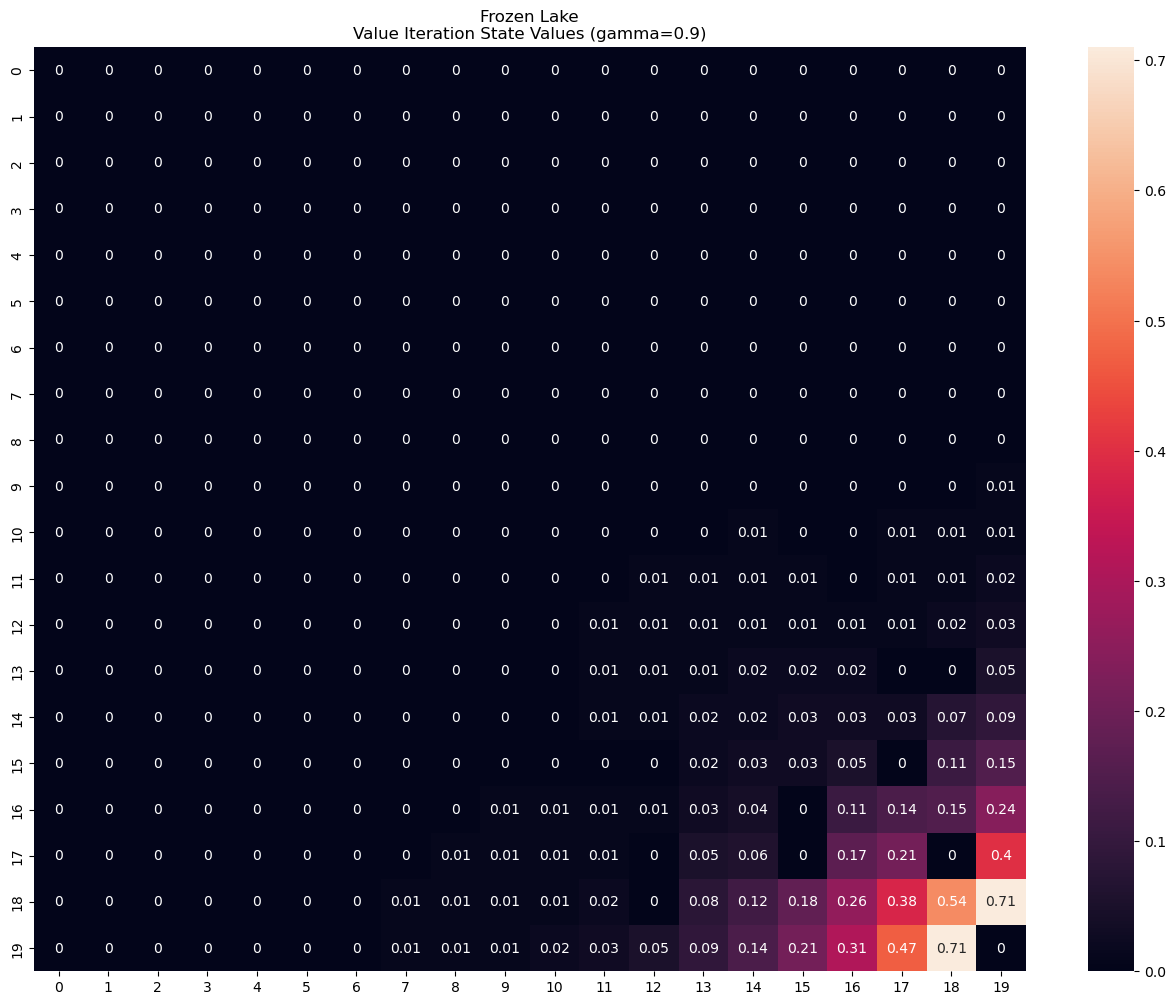

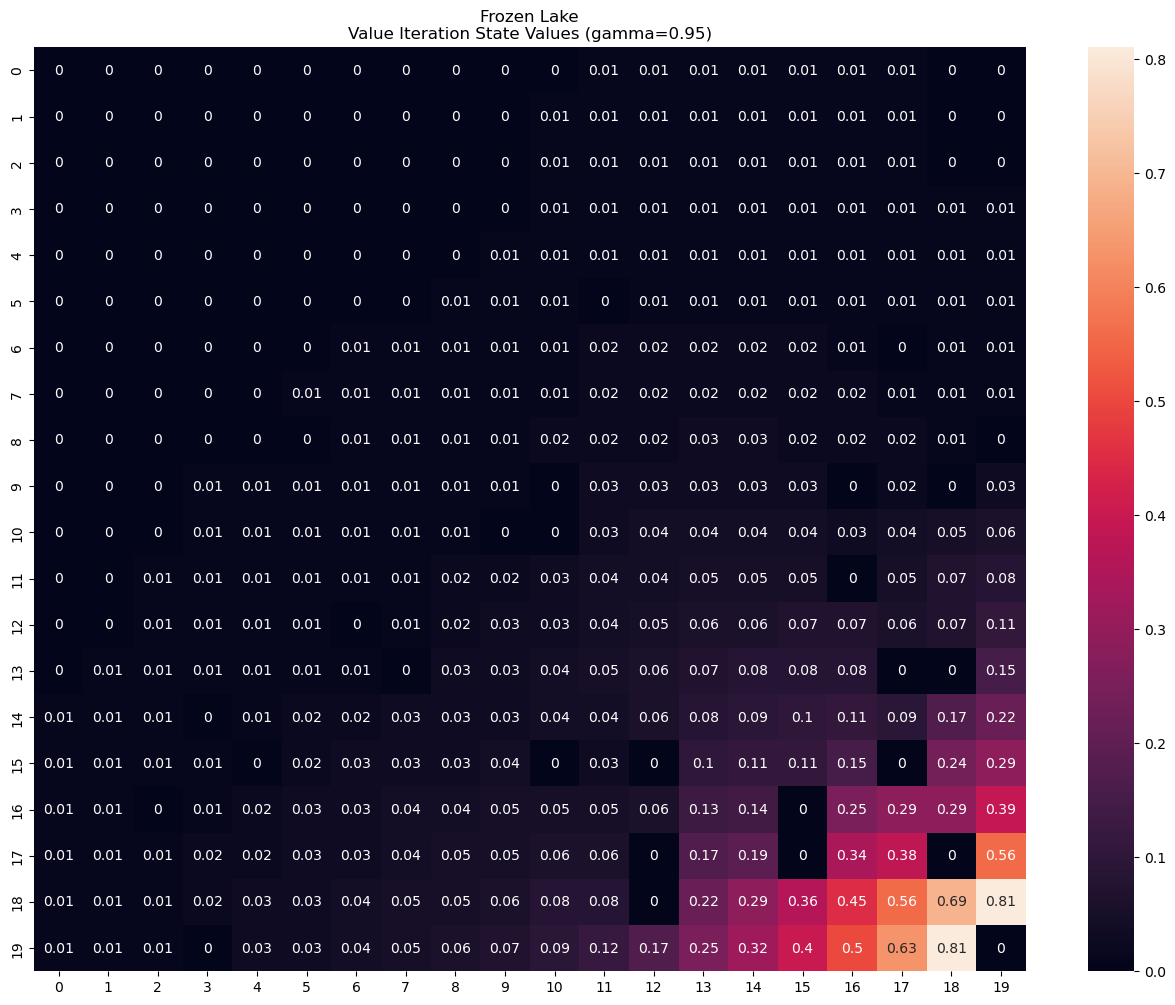

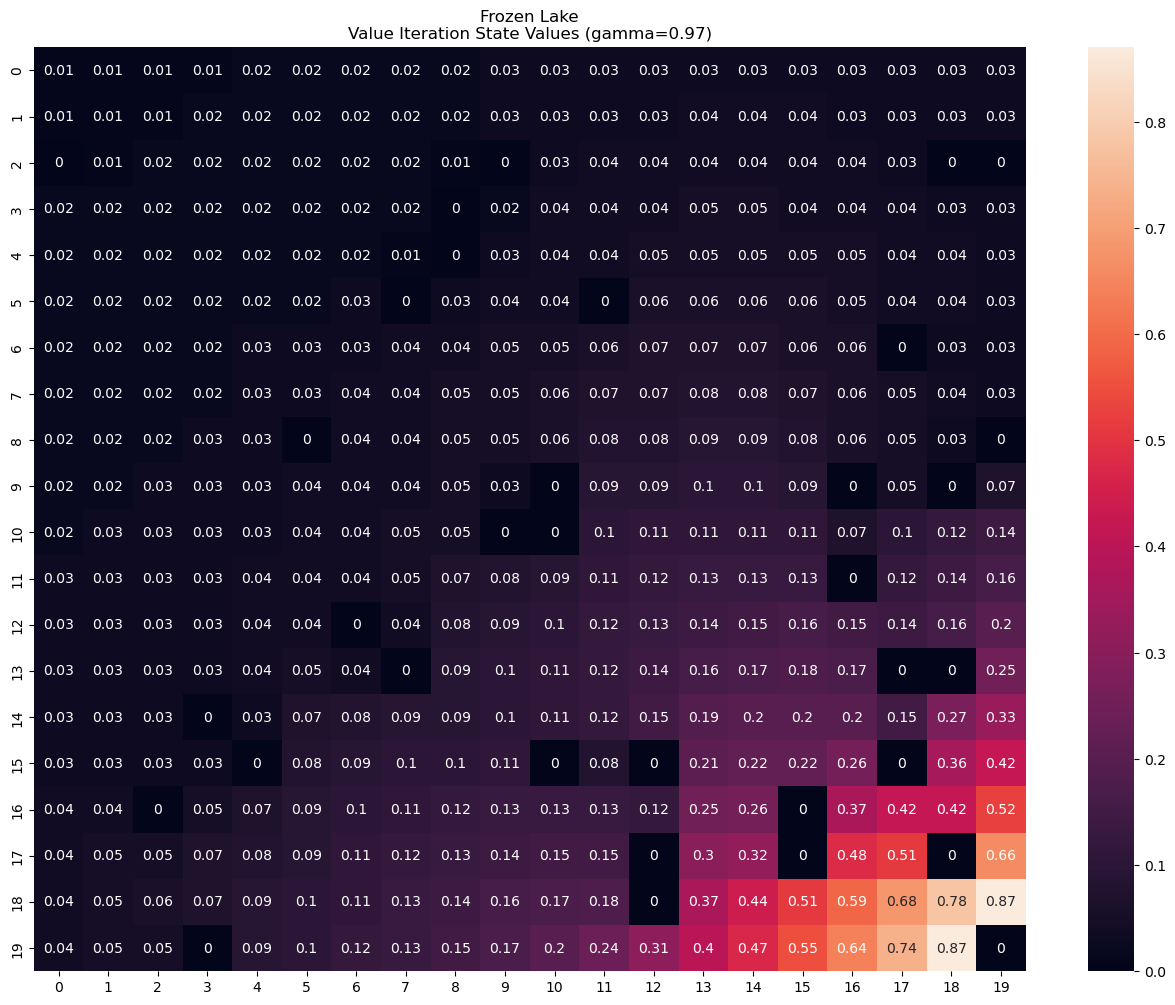

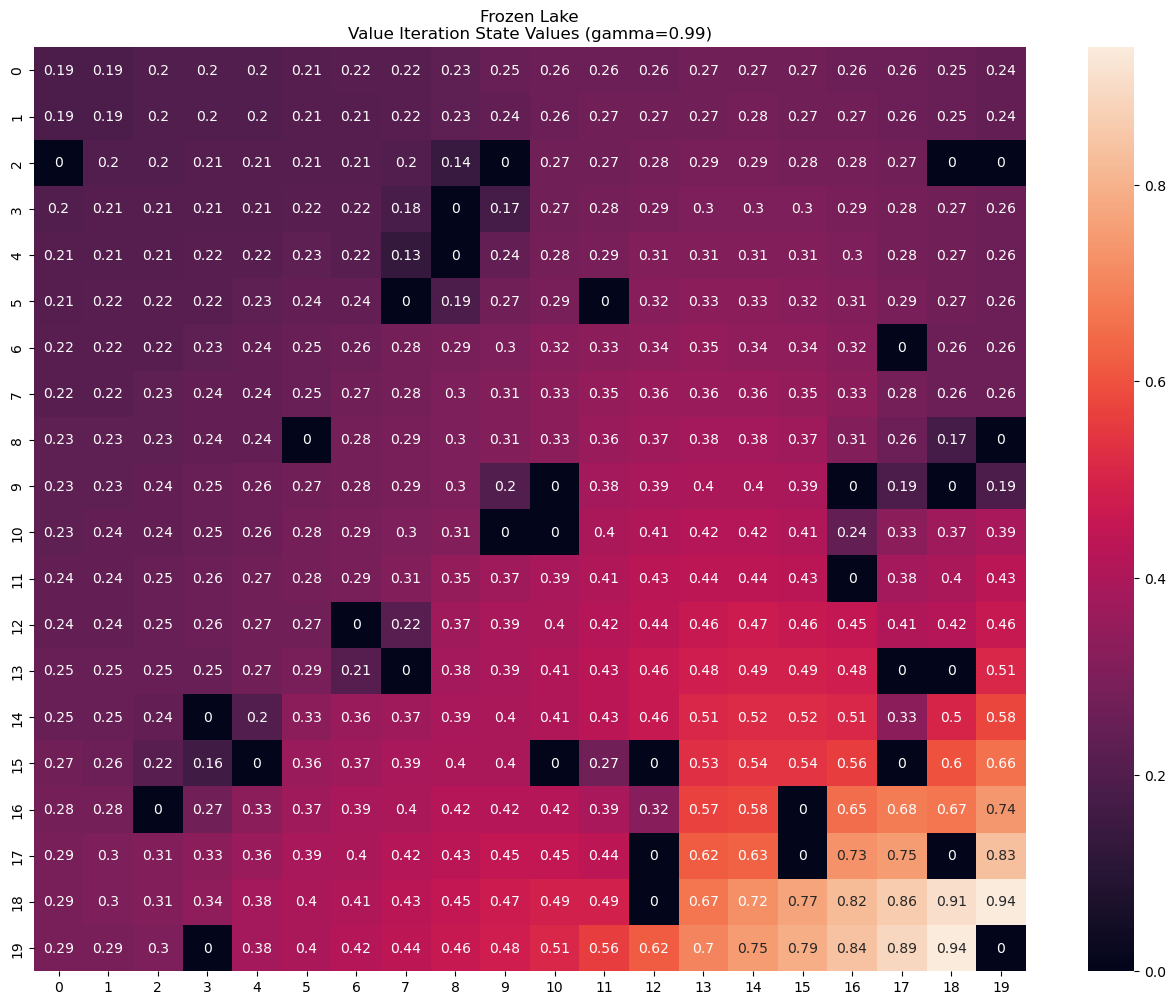

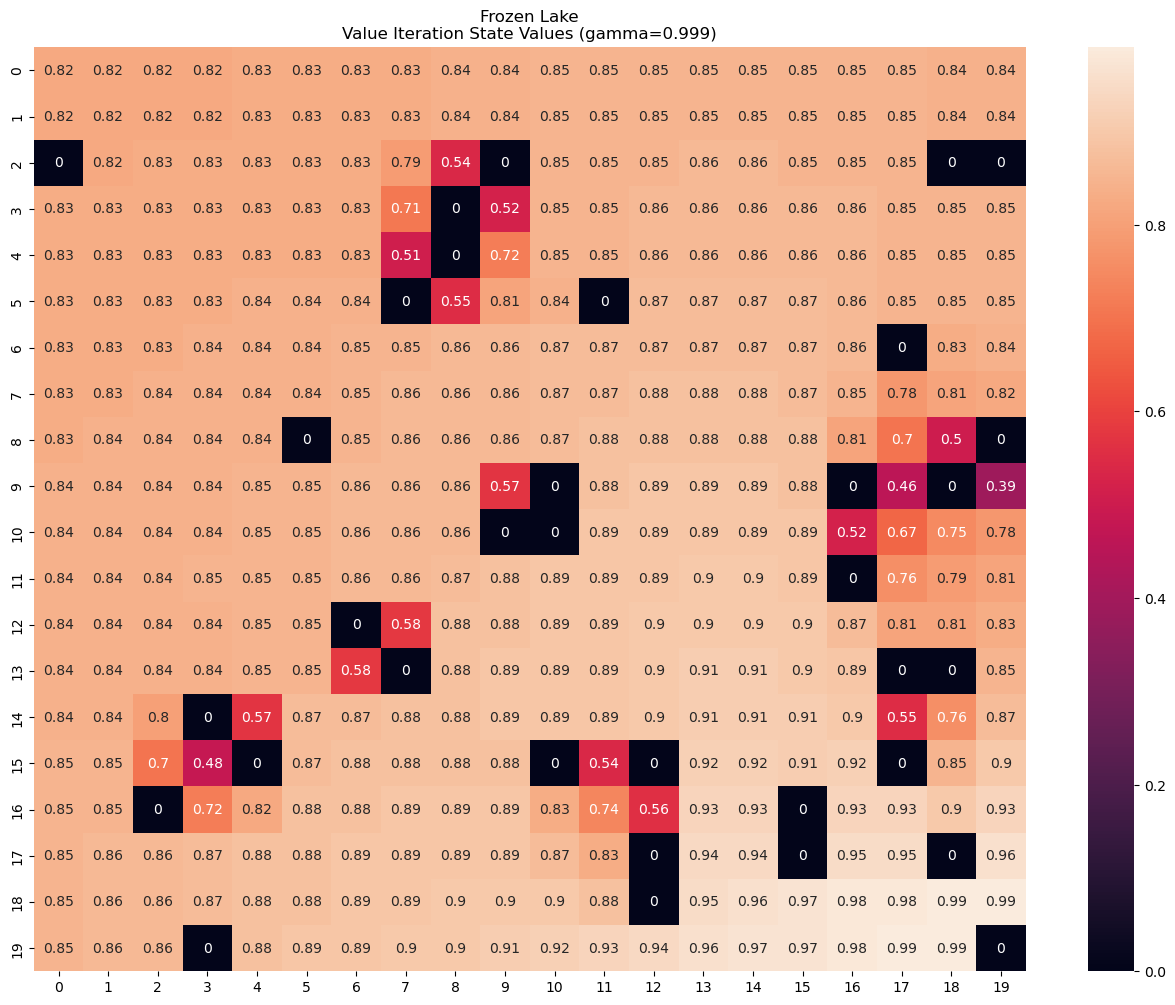

In [3]:
frozen_lake = gym.make('FrozenLake-v1', desc=grid_size, is_slippery=True)

gammas = [0.9, 0.95, 0.97, 0.99, 0.999]
V = {}
V_track = {}
pi = {}

for gamma in gammas:
    V[gamma], V_track[gamma], pi[gamma] = Planner(frozen_lake.P).value_iteration(gamma=gamma, n_iters=1000, theta=1e-6)

#plot state values
size=(20, 20)
for gamma in gammas:
    plt.figure(figsize=(16, 12))
    Plots.values_heat_map(V[gamma], f"Frozen Lake\nValue Iteration State Values (gamma={gamma})", size)

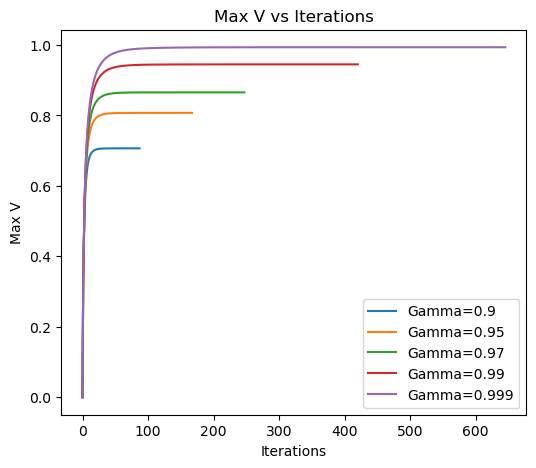

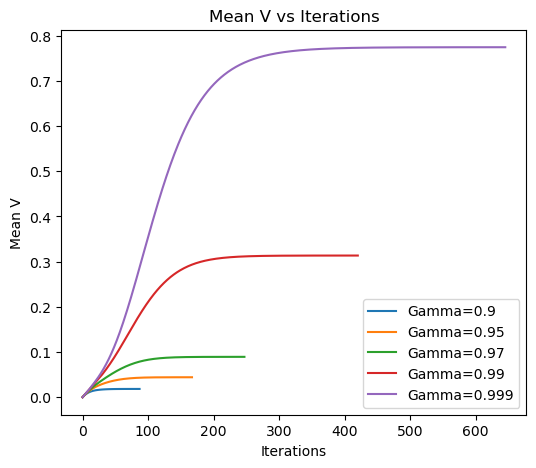

In [4]:
# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
max_value_per_iter = {}
mean_value_per_iter = {}

for gamma in gammas:
    max_value_per_iter[gamma] = np.trim_zeros(np.max(V_track[gamma], axis=1), 'b')
    mean_value_per_iter[gamma] = np.trim_zeros(np.mean(V_track[gamma], axis=1), 'b')
# Plot max_v vs iterations
plt.figure(figsize=(6, 5))
for gamma in gammas:
    plt.plot(max_value_per_iter[gamma], label=f"Gamma={gamma}")
plt.xlabel("Iterations")
plt.ylabel("Max V")
plt.title("Max V vs Iterations")
plt.legend()
plt.show()

# Plot mean_v vs iterations
plt.figure(figsize=(6, 5))
for gamma in gammas:
    plt.plot(mean_value_per_iter[gamma], label=f"Gamma={gamma}")
plt.xlabel("Iterations")
plt.ylabel("Mean V")
plt.title("Mean V vs Iterations")
plt.legend()
plt.show()

Time Elapsed: 122.99198746681213 seconds


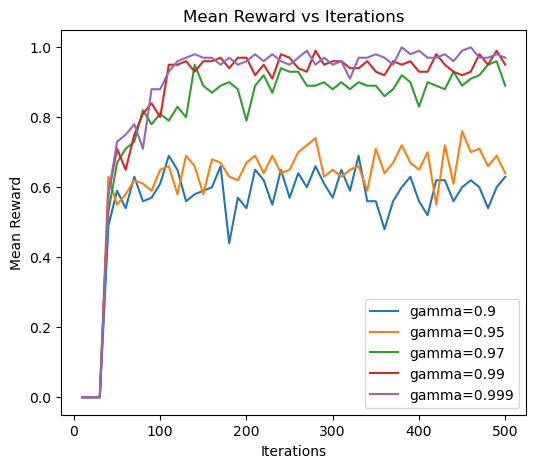

In [5]:
frozen_lake._max_episode_steps = 400
test_env = TestEnv()
reward_vi = {}
plot_range = range(10,501,10)
gammas = [0.9, 0.95, 0.97, 0.99, 0.999]
start_time = time()
for gamma in gammas:
    reward_vi[gamma] = []
    for n in plot_range:
        np.random.seed(2)
        V_tmp, V_track_tmp, pi_tmp = Planner(frozen_lake.P).value_iteration(gamma=gamma, n_iters=n, theta=1e-6)
        reward_tmp = test_env.test_env(frozen_lake, render=False, pi=pi_tmp, n_iters=100)
        reward_vi[gamma].append(np.mean(reward_tmp))
        clear_output(wait=True)
end_time = time()
time_elapsed = end_time - start_time
print(f"Time Elapsed: {time_elapsed} seconds")

plt.figure(figsize=(6, 5))
for key, value in reward_vi.items():
    plt.plot(plot_range, reward_vi[key], label=f"gamma={key}")
plt.xlabel("Iterations")
plt.ylabel("Mean Reward")
plt.title("Mean Reward vs Iterations")
plt.legend()
plt.show()

runtime = 0.93 seconds


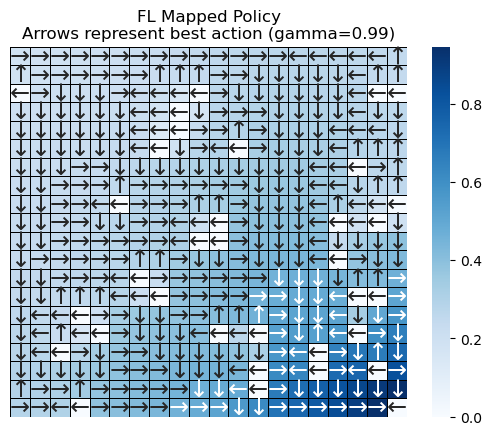

In [6]:
fl_actions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
fl_map_size = (frozen_lake.nrow, frozen_lake.ncol)
gamma = 0.99
np.random.seed(2)
V, V_track, pi = Planner(frozen_lake.P).value_iteration(gamma=gamma, n_iters=1000, theta=1e-6)
val_max, policy_map = Plots.get_policy_map(pi, V, fl_actions, fl_map_size)
title = f"FL Mapped Policy\nArrows represent best action (gamma={gamma})"
Plots.plot_policy(val_max, policy_map, fl_map_size, title)
plt.show()

## Policy Iteration

runtime = 0.15 seconds
runtime = 0.24 seconds
runtime = 0.38 seconds
runtime = 0.70 seconds
runtime = 1.33 seconds
runtime = 1.04 seconds


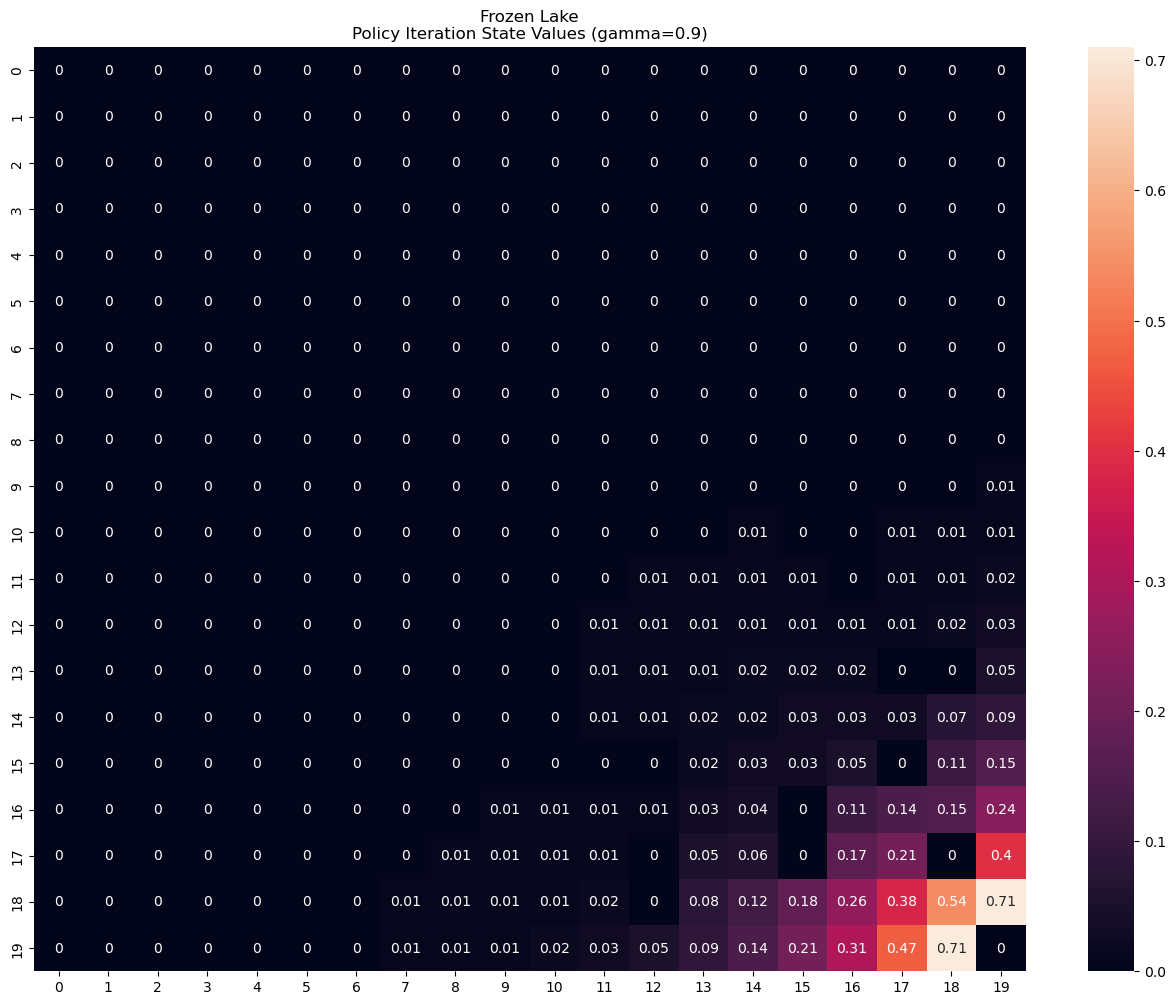

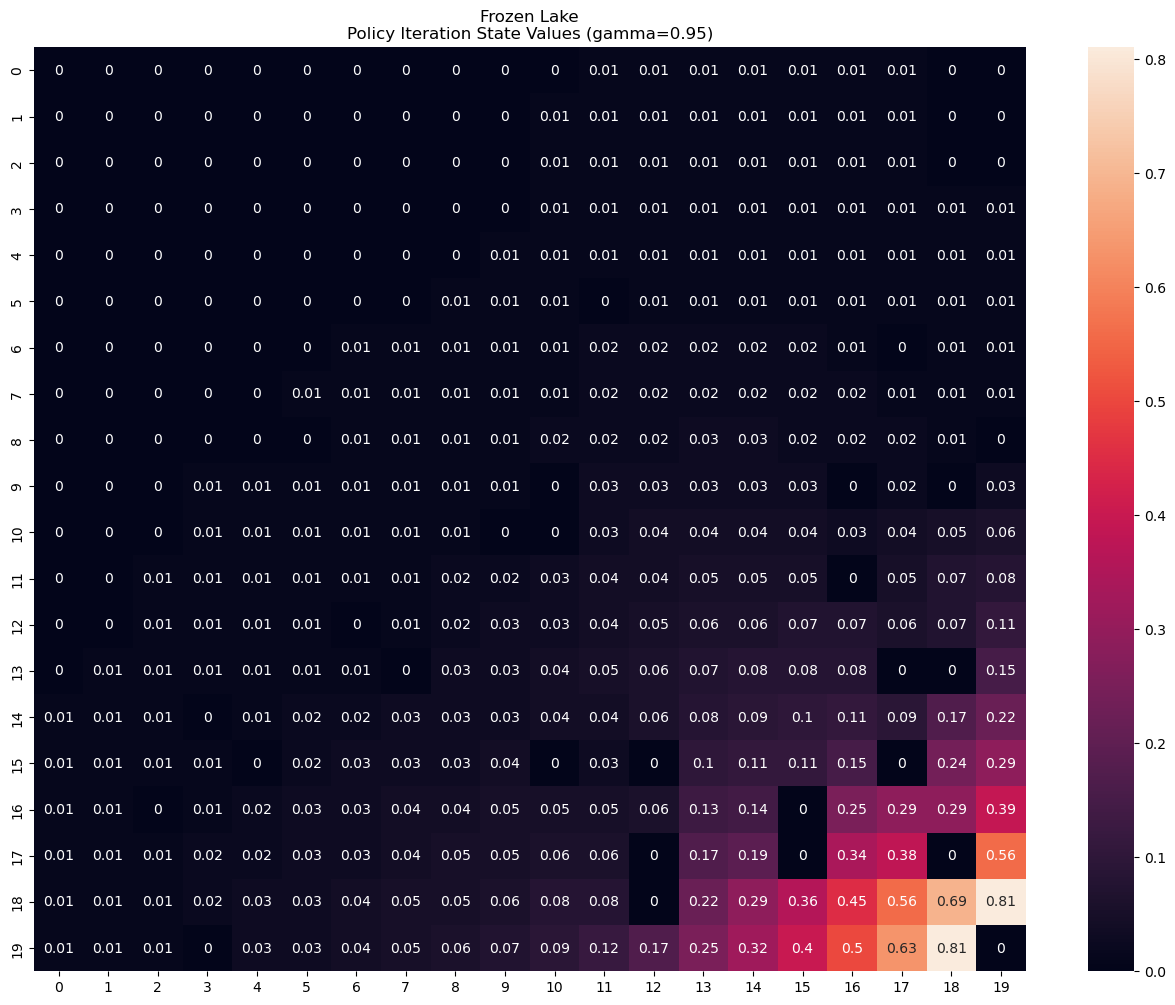

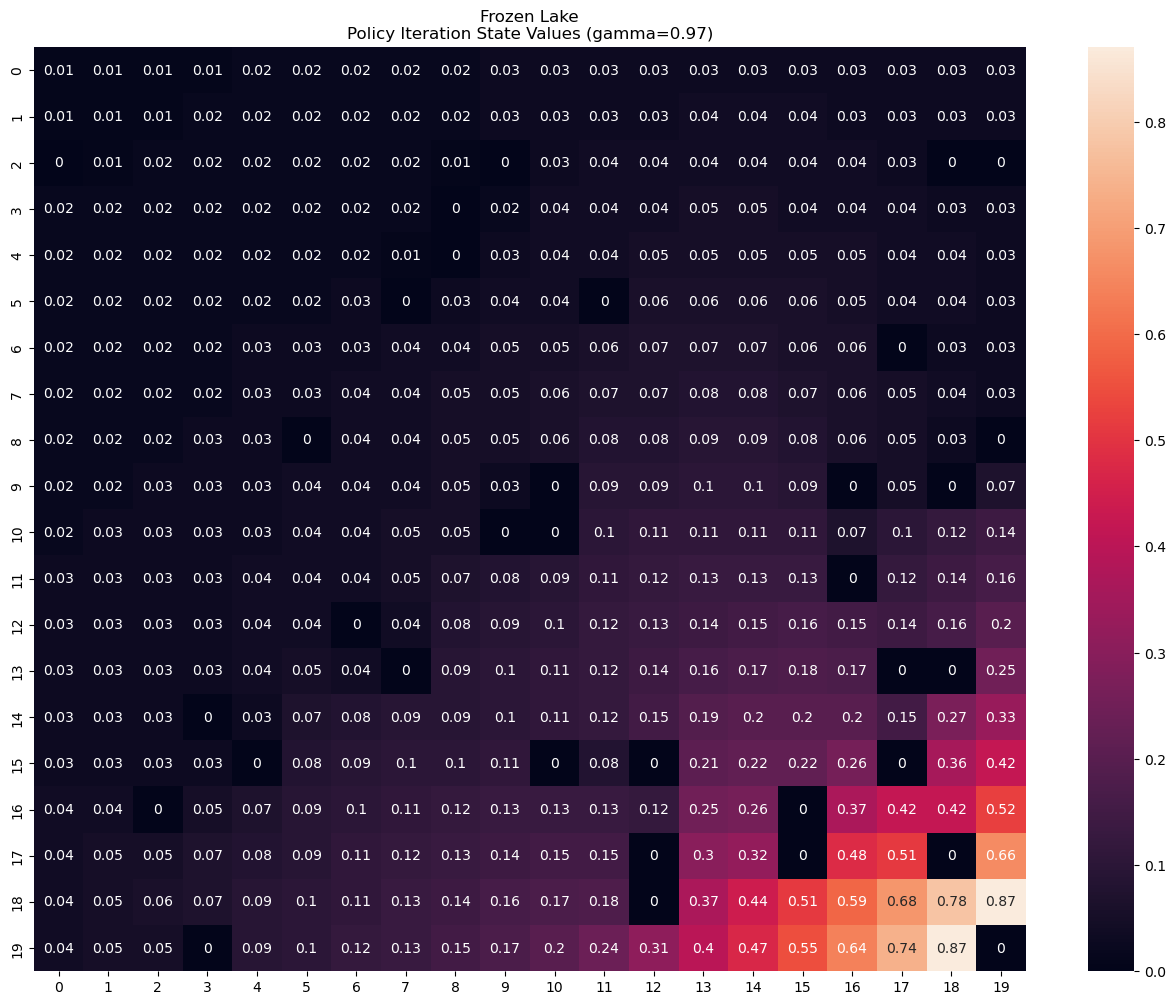

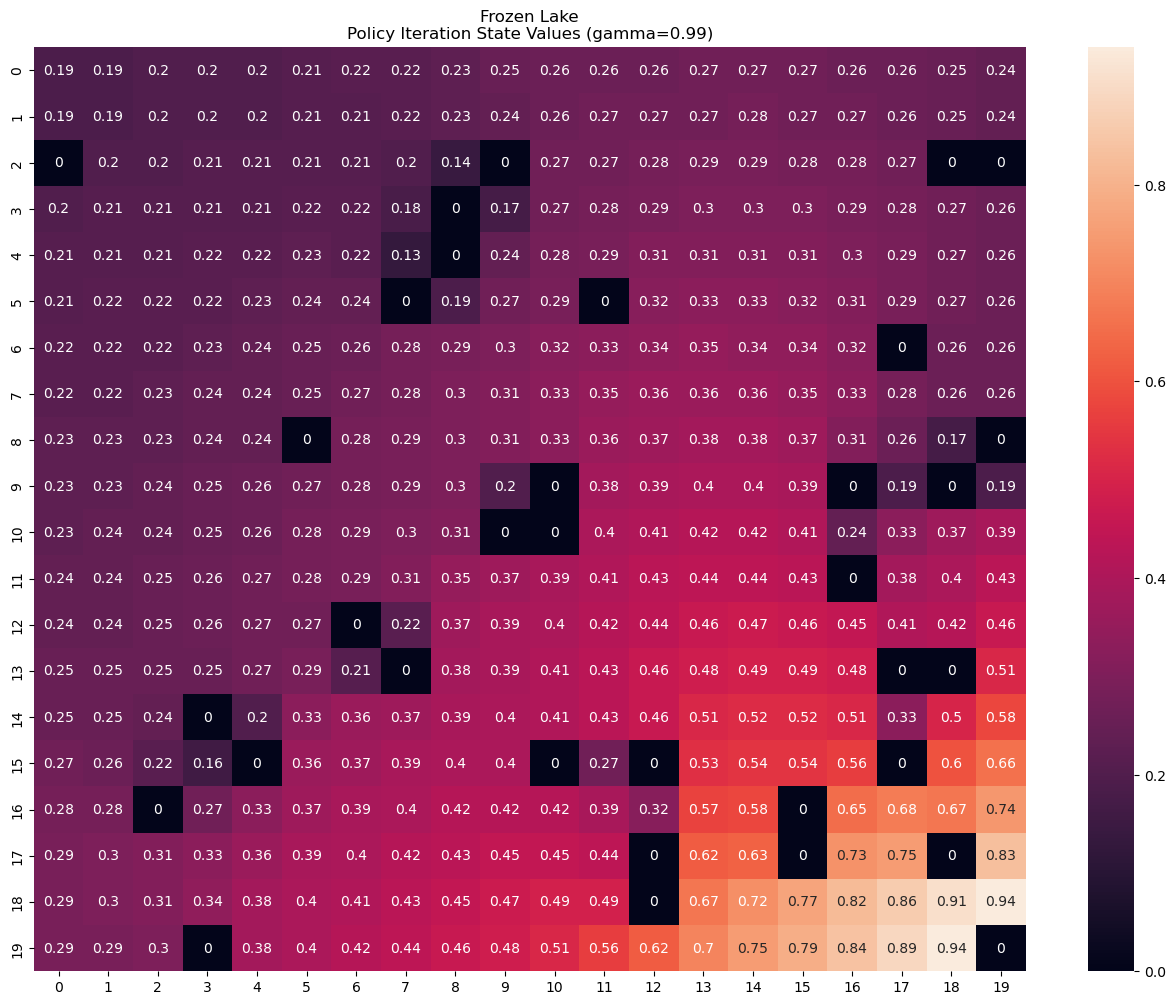

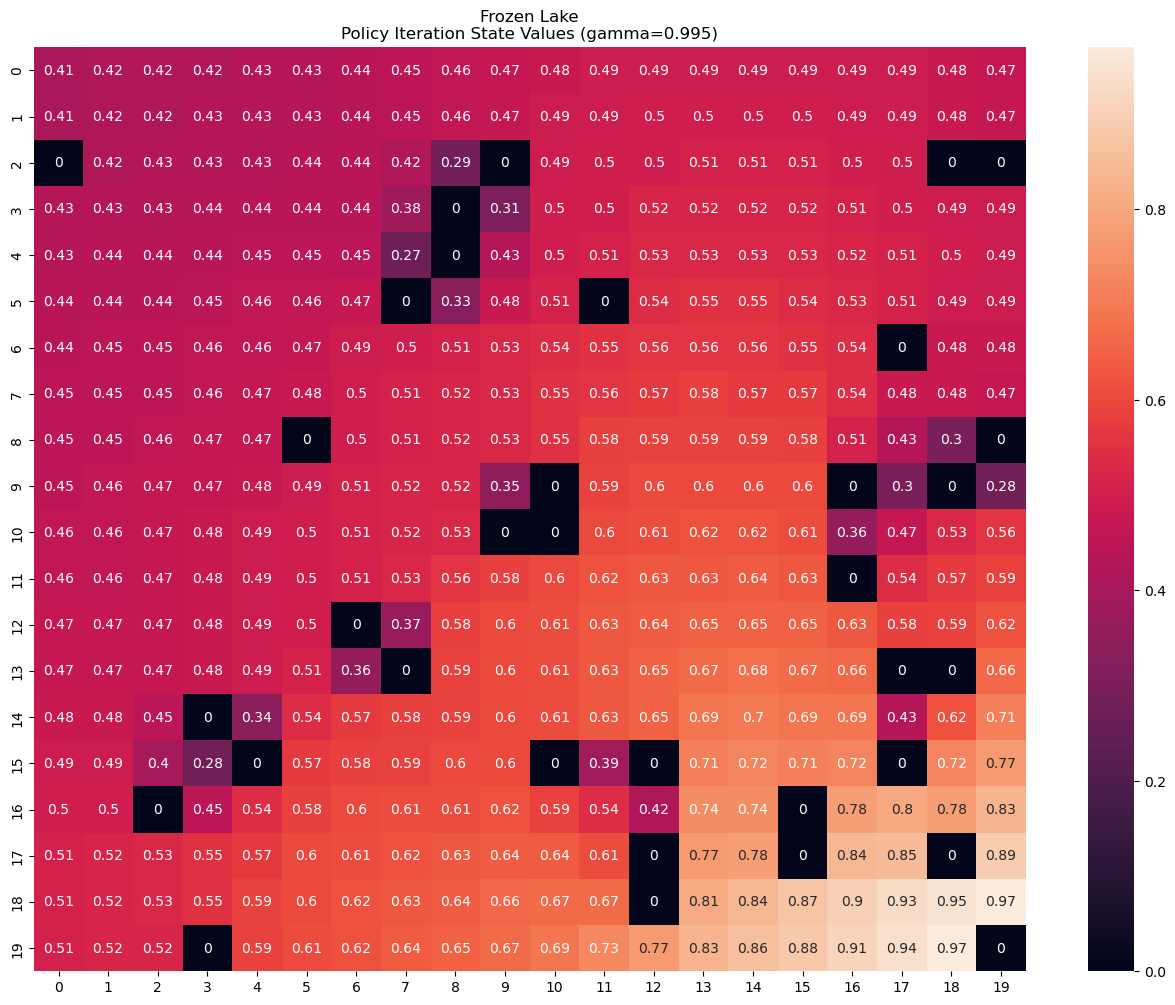

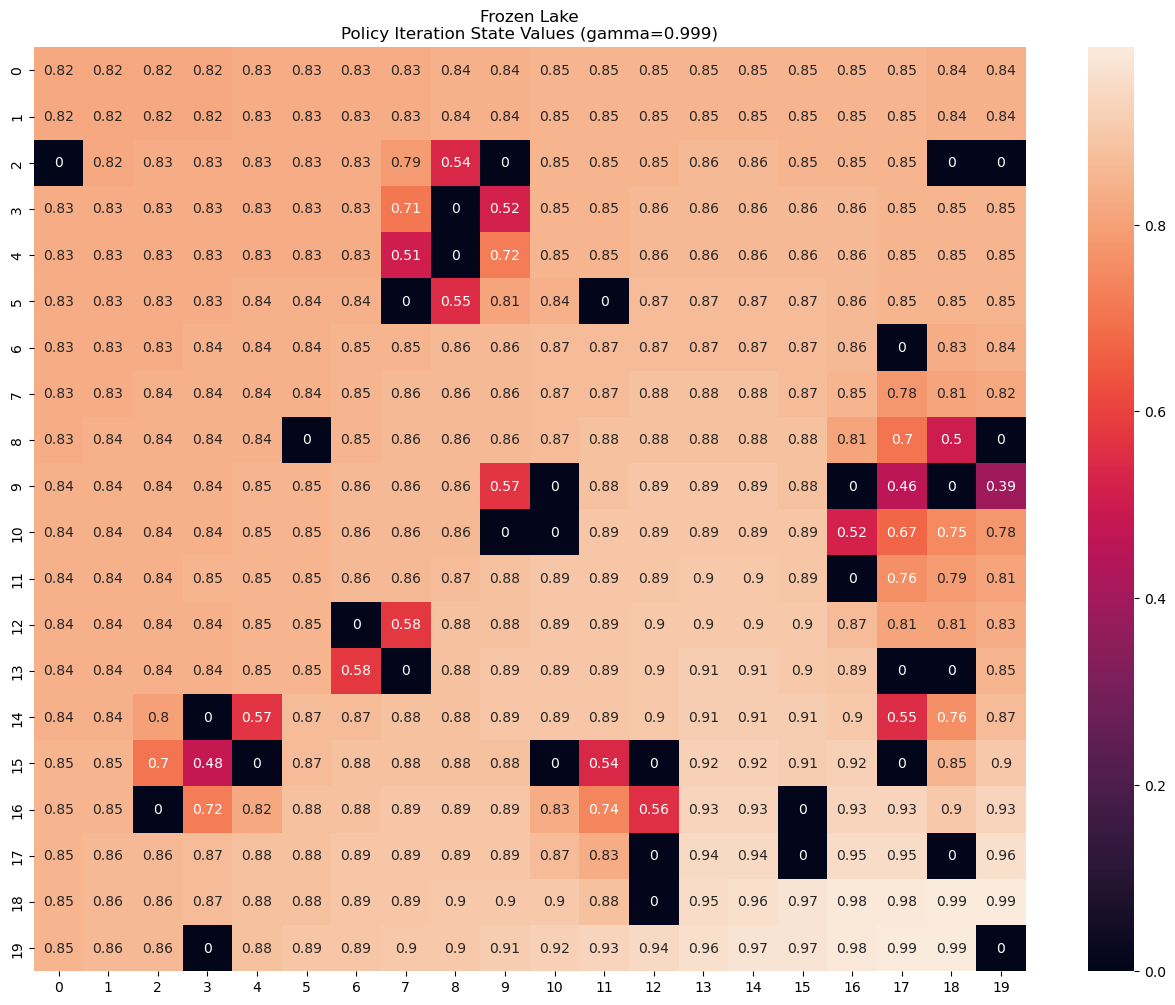

In [7]:
np.random.seed(2)
grid_size = generate_random_map(size=20, p=0.9)
frozen_lake = gym.make('FrozenLake-v1', desc=grid_size, is_slippery=True)

gammas = [0.9, 0.95, 0.97, 0.99, 0.995, 0.999]
V = {}
V_track = {}
pi = {}

for gamma in gammas:
    V[gamma], V_track[gamma], pi[gamma] = Planner(frozen_lake.P).policy_iteration(gamma=gamma, n_iters=1000, theta=1e-6)

#plot state values
size=(20, 20)
for gamma in gammas:
    plt.figure(figsize=(16, 12))
    Plots.values_heat_map(V[gamma], f"Frozen Lake\nPolicy Iteration State Values (gamma={gamma})", size)

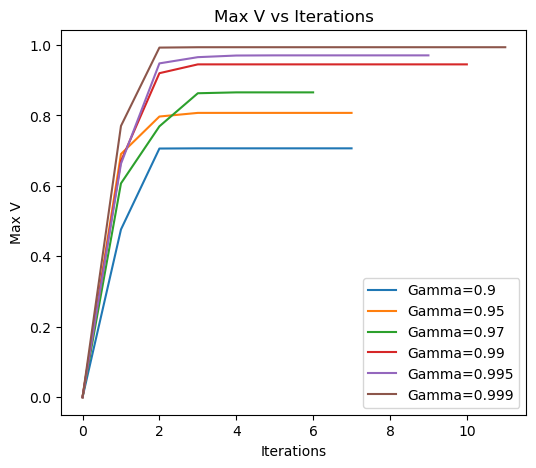

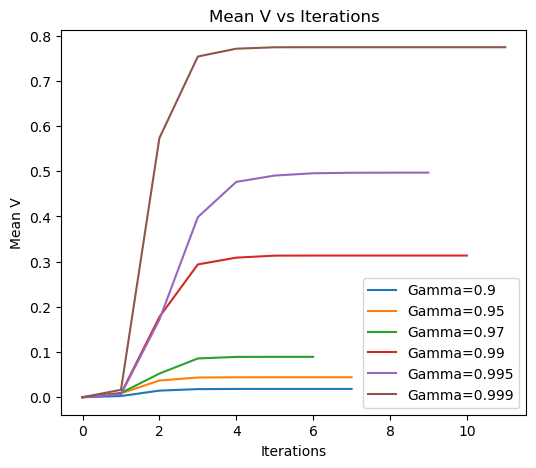

In [8]:
# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
max_value_per_iter = {}
mean_value_per_iter = {}

for gamma in gammas:
    max_value_per_iter[gamma] = np.trim_zeros(np.max(V_track[gamma], axis=1), 'b')
    mean_value_per_iter[gamma] = np.trim_zeros(np.mean(V_track[gamma], axis=1), 'b')
# Plot max_v vs iterations
plt.figure(figsize=(6, 5))
for gamma in gammas:
    plt.plot(max_value_per_iter[gamma], label=f"Gamma={gamma}")
plt.xlabel("Iterations")
plt.ylabel("Max V")
plt.title("Max V vs Iterations")
plt.legend()
plt.show()

# Plot mean_v vs iterations
plt.figure(figsize=(6, 5))
for gamma in gammas:
    plt.plot(mean_value_per_iter[gamma], label=f"Gamma={gamma}")
plt.xlabel("Iterations")
plt.ylabel("Mean V")
plt.title("Mean V vs Iterations")
plt.legend()
plt.show()

Time Elapsed: 20.01808261871338 seconds


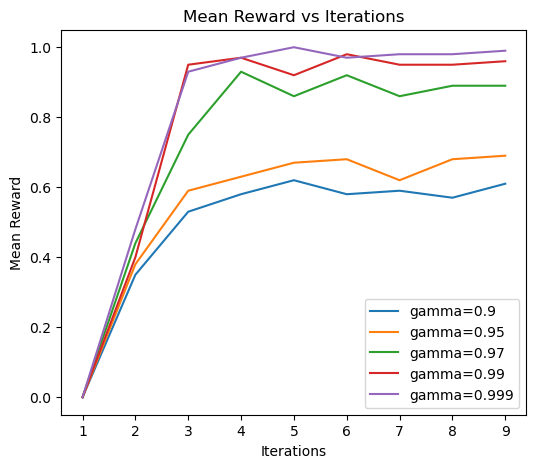

In [9]:
frozen_lake._max_episode_steps = 500
test_env = TestEnv()
reward_vi = {}
plot_range = range(1,10)
gammas = [0.9, 0.95, 0.97, 0.99, 0.999]
start_time = time()
for gamma in gammas:
    reward_vi[gamma] = []
    for n in plot_range:
        np.random.seed(21321421)
        V_tmp, V_track_tmp, pi_tmp = Planner(frozen_lake.P).policy_iteration(gamma=gamma, n_iters=n, theta=1e-6)
        reward_tmp = test_env.test_env(frozen_lake, render=False, pi=pi_tmp, n_iters=100)
        reward_vi[gamma].append(np.mean(reward_tmp))
        clear_output(wait=True)
end_time = time()
time_elapsed = end_time - start_time
print(f"Time Elapsed: {time_elapsed} seconds")

plt.figure(figsize=(6, 5))
for key, value in reward_vi.items():
    plt.plot(plot_range, reward_vi[key], label=f"gamma={key}")
plt.xlabel("Iterations")
plt.ylabel("Mean Reward")
plt.title("Mean Reward vs Iterations")
plt.legend()
plt.show()

runtime = 0.76 seconds


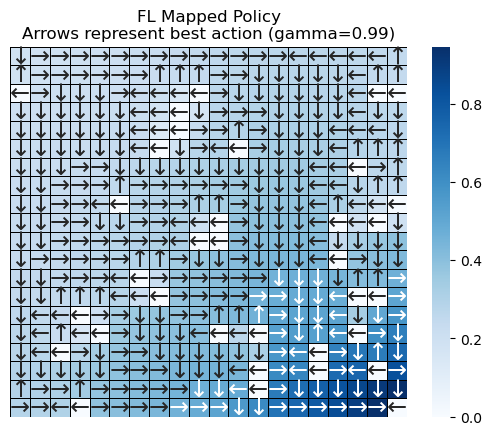

In [10]:
fl_actions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
fl_map_size = (frozen_lake.nrow, frozen_lake.ncol)
gamma = 0.99
np.random.seed(2)
V, V_track, pi = Planner(frozen_lake.P).policy_iteration(gamma=gamma, n_iters=1000, theta=1e-6)
val_max, policy_map = Plots.get_policy_map(pi, V, fl_actions, fl_map_size)
title = f"FL Mapped Policy\nArrows represent best action (gamma={gamma})"
Plots.plot_policy(val_max, policy_map, fl_map_size, title)
plt.show()